In [1]:
import os
import numpy as np 
np.random.seed(7)

import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import copy 
import pandas as pd
import time
import datetime

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tslearn.clustering import TimeSeriesKMeans


# Preprocessing


In [2]:
#For scaling all the houses at once
# Dataset = r'../15minute_data_newyork/15minute_data_newyork.csv'
# fulldata = pd.read_csv(Dataset) 
# data=fulldata[['dataid','local_15min','grid']]
# scaler = MinMaxScaler(feature_range=(0, 1))

# dataset = np.matrix(data['grid'].values).transpose()
# dataset = dataset.astype('float32')
# dataset = scaler.fit_transform(dataset)
# data['grid'] = pd.Series(dataset.flatten())

In [3]:
Dataset = r'../15minute_data_newyork/15minute_data_newyork.csv'
fulldata = pd.read_csv(Dataset) 
data=fulldata[['dataid','local_15min','grid']]
sorteddata=data.sort_values(by = ['dataid', 'local_15min'])
ids=sorteddata['dataid'].unique().tolist()
housing_data = []
housing_data_numpy = []
def convertDate(d):
    d = pd.to_datetime(d[:-3])
    return d 

for i in range(len(ids)):
    housing_data.append(sorteddata.loc[sorteddata.dataid==ids[i]])
    housing_data[i] = housing_data[i].reset_index().drop(columns=['index'])
    # housing_data[i]['local_15min'] = housing_data[i]['local_15min'].apply(convertDate)
    #Convert datetimes to ints for faster ploting 
    # housing_data[i]['15min_ints'] =  housing_data[i]['local_15min'].map(mdates.date2num)


In [4]:
def create_dataset(dataset, look_back=1, look_ahead=None):
	"function for creating dataset for model, X being the known data, and Y being target data"
	if look_ahead is None:
		look_ahead = look_back
	dataX, dataY = [], []
	for i in range(len(dataset)-2*look_back):
		dataX.append(dataset[i:(i+look_back), 0])
		if look_ahead == 0:
			dataY.append(dataset[i + look_back, 0])
		else:
			dataY.append(dataset[(i+look_back):(i+look_back+look_ahead), 0])
		
	return np.array(dataX), np.array(dataY)

In [5]:
#one house case
# dataframe = pd.concat([housing_data[0]['grid'], housing_data[1]['grid']]) 
# for i in range(2, len(ids)):
#     dataframe = pd.concat([dataframe,housing_data[i]['grid'] ])
# dataset = np.matrix(dataframe.values).transpose()
# dataset = dataset.astype('float32')    
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)

In [6]:
def dataset_per_house(house, look_back = 96):
    dataframe = house['grid']
    dataset = np.matrix(dataframe.values).transpose()
    dataset = dataset.astype('float32')

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    print(len(dataset)) #just to somewhat prove that the dataset aren't the same
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:,:]
    # look_back = 96 #(60mins/15min)*24 hours
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    return trainX, trainY, testX, testY, dataset, scaler

In [7]:
def get_avg_day(look_back =96,  house = 0, absolute = False):

    dataframe = housing_data[house]['grid']
    fulldays=len(dataframe)//look_back
    grid_data=dataframe.to_numpy()

    grid_day_matrix=grid_data[:(look_back*fulldays)].reshape(-1, look_back)
    if absolute == True:
        grid_day_matrix = abs(grid_day_matrix)
    #avg house0 grid data 
    avg_house_grid=np.mean(grid_day_matrix, axis=0)
    # print(grid_day_matrix.shape)
    return avg_house_grid

def get_avg_day_from_predict(data, look_back =96, absolute = False):
    grid_day_matrix= data[::look_back]
    if absolute == True:
        grid_day_matrix = abs(grid_day_matrix)
    #avg house0 grid data 
    avg_house_grid=np.mean(grid_day_matrix, axis=0)
    return avg_house_grid

In [8]:
avg_house_list = []
for i in range(len(housing_data)):
    avg_house_list.append(get_avg_day(house= i))
np_avg_house = np.asarray(avg_house_list) 
r,c =np_avg_house.shape
np_avg_house_3d = np.reshape(np_avg_house,(r,c,1))

In [9]:
np_avg_house.shape

(25, 96)

In [10]:
KMmodel=TimeSeriesKMeans.from_hdf5('../models/KM/KM1.h5')

In [11]:
houseclasses= KMmodel.fit_predict(np_avg_house_3d)

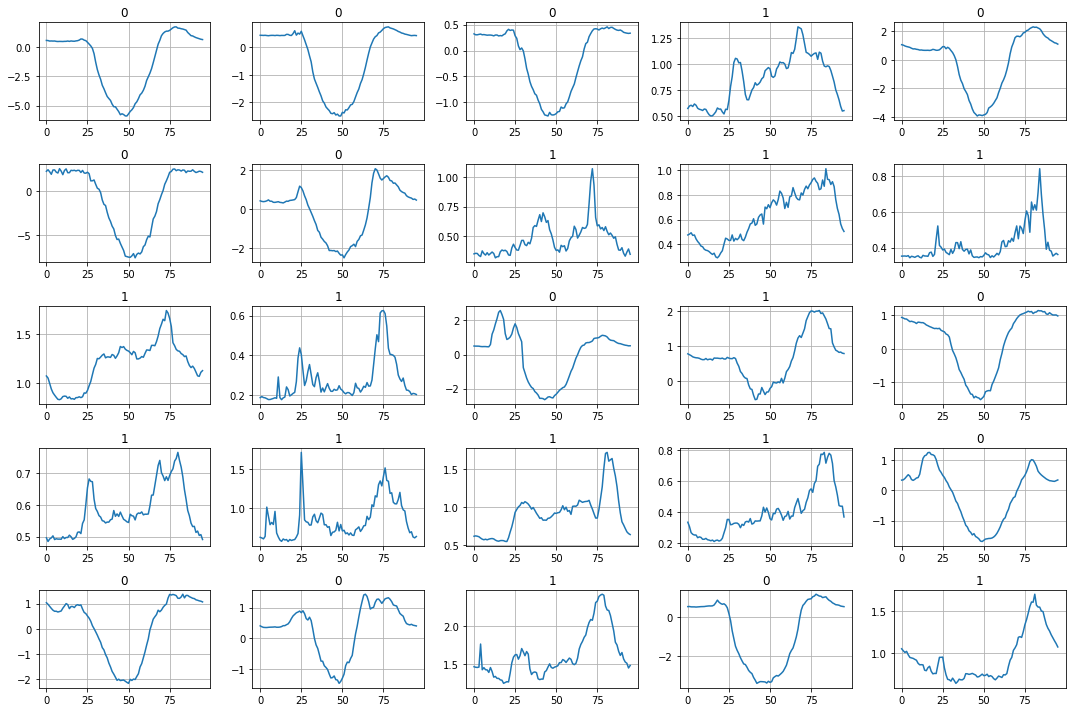

In [12]:
plt.figure(figsize=(15, 10))
for i in range(len(avg_house_list)):
    # avg_house_grid_list.append(get_avg_day(house= i))
    plt.subplot(5,5,i+1) 
    plt.plot(avg_house_list[i])
    plt.title(f'{houseclasses[i]}')
    plt.grid(True)
plt.tight_layout()

In [13]:
solarhouses0 = []
nonsolarhouses1 = []
for i, classes in enumerate(houseclasses): 
    if classes==0:
        solarhouses0.append(housing_data[i])
    else: 
        nonsolarhouses1.append(housing_data[i])

numofsolarhouses = len(solarhouses0)
numofnonsolarhouses = len(nonsolarhouses1)

In [14]:
numbertrainingsolarhouse=int(numofsolarhouses * 2/3)
numbertraininghouse=int(numofnonsolarhouses * 3/4)

In [15]:
print(numbertraininghouse)
print(numofnonsolarhouses)

9
13


In [16]:
listoftrainX = []
listoftrainY =[]
listoftestX = []
listoftestY = []
listofdataset = []
listofscaler = []
for i in range(numbertraininghouse ):
    trainX, trainY, testX, testY, dataset, scaler =dataset_per_house(nonsolarhouses1[i])
    listoftrainX.append(trainX)
    listoftrainY.append(trainY)
    listoftestX.append(testX)
    listoftestY.append(testY)
    listofdataset.append(dataset)
    listofscaler.append(scaler)



17664
17664
17664
17664
17664
17664
17664
17664
17664


In [17]:
#get val data

listofvaltrainX = []
listofvaltrainY =[]
listofvaltestX = []
listofvaltestY = []
listofvaldataset = []
# listofvalscalersolar = []
for i in range(numbertraininghouse, numofnonsolarhouses):
    trainX, trainY, testX, testY, dataset, scaler=dataset_per_house(nonsolarhouses1[i])
    listofvaltrainX.append(trainX)
    listofvaltrainY.append(trainY)
    listofvaltestX.append(testX)
    listofvaltestY.append(testY)
    listofvaldataset.append(dataset)
    listofscaler.append(scaler)

17664
17664
17664
17664


In [18]:
trainY.shape
# len(listofscalersolar)

(11642, 96)

In [19]:
def reshape_stack_reshapeX(X): 
    r,c,z=X[0].shape
    x0 = X[0].reshape(r,c)
    for i, x in enumerate(X):
        if i == 0:
            continue
        r,c,z = x.shape 
        x = x.reshape(r,c)

        x0 = np.vstack((x0,x))
    # print(x0.shape)
    r,c= x0.shape
    x0 = x0.reshape(r,c,1)
    return x0

def reshape_stack_reshapeY(Y, starting_point = 0):     
    y0 = Y[0]
    # print(y0.shape)
    scaler_mapper = (np.zeros(y0.shape) + starting_point)
    for i, y in enumerate(Y):
        if i == 0:
            continue
        scaler_mapper_next = (i*np.ones(y.shape) + starting_point)
        scaler_mapper = np.vstack((scaler_mapper,scaler_mapper_next))
        y0 = np.vstack((y0,y))
    # r,c,= y0.shape
    # y0 = y0.reshape(r,c)
    # print(y0.shape)
    return y0, scaler_mapper

def reshape_stack_reshapedata(data):
    
    r,c = data[0].shape
    # print()
    data0 = data[0].reshape(r)
    # scaler_mapper = [(np.zeros(data0.shape) + starting_point).flatten()]
    for i, points in enumerate(data):
        if i == 0:
            continue
        # points = points.flatten()
        r,c = points.shape
        points = points.reshape(r)
        # scaler_mapper.append((i*np.ones(points.shape) + starting_point).flatten())
        data0 = np.hstack((data0,points))
    # # r, = data0.shape
    # print(data0.shape)
    # data0 = data0.reshape(r,1)
    data0 = data0.transpose()
    # print(data0.shape)
    
    return data0
trainX = reshape_stack_reshapeX(listoftrainX)
trainY, train_scaler_mapper = reshape_stack_reshapeY(listoftrainY)
testX = reshape_stack_reshapeX(listoftestX)
testY, test_scaler_mapper = reshape_stack_reshapeY(listoftestY)
dataset  = reshape_stack_reshapedata(listofdataset)

valtrainX = reshape_stack_reshapeX(listofvaltrainX)
valtrainY, valtrain_scaler_mapper = reshape_stack_reshapeY(listofvaltrainY, train_scaler_mapper[-1][0]+1)
valtestX = reshape_stack_reshapeX(listofvaltestX)
valtestY, valtest_scaler_mapper = reshape_stack_reshapeY(listofvaltestY, test_scaler_mapper[-1][0]+1)
valdataset = reshape_stack_reshapedata(listofvaldataset)



In [20]:
dataset.shape

(158976,)

# LSTM

In [20]:
# create and fit the LSTM network
opm = 'adam'
look_back = 96
model = Sequential()
model.add(LSTM(32, input_shape=(look_back, 1))) #32
model.add(Dropout(0.3)) #.2
model.add(Dense(look_back))
model.compile(loss='mean_squared_error', optimizer=opm , metrics=['RootMeanSquaredError'] )
model_mdata = model.fit(trainX, trainY, epochs=3, batch_size=1, verbose=1, shuffle=True, use_multiprocessing=True, validation_data = (valtrainX,valtrainY ))
scores = model.evaluate(testX, testY)
print(f"Avg Losses: {scores}" )
# print(model_mdata.history)

Epoch 1/3
93136/93136 [==============================] - 4149s 45ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 2/3
93136/93136 [==============================] - 4174s 45ms/step - loss: 0.0055 - root_mean_squared_error: 0.0742 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1082
Epoch 3/3
1410/1410 [==============================] - 87s 62ms/step - loss: 0.0044 - root_mean_squared_error: 0.0666
Avg Losses: [0.004429644905030727, 0.06655557453632355]


In [21]:
# plt.plot(model_mdata.history['root_mean_squared_error'])
# plt.plot(model_mdata.history['val_root_mean_squared_error'])
# plt.title('Solar Model Accuracy vs. Epoch')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['train','test'], loc='upper left')
# plt.tight_layout()
# plt.show()

In [22]:
# plt.plot(model_mdata.history['loss'])
# plt.plot(model_mdata.history['val_loss'])
# plt.title('Solar Model Loss vs. Epoch')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.tight_layout()
# # plt.show()

In [23]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [24]:
trainPredict[0].shape

(96,)

In [25]:
def unscale_per_house(listofscales, scalemap, data, lookback = 96):
    # print(data.shape)
    unscaled_data = []
    for i,row in enumerate(scalemap):
        # print(i)
        # print(row[-1])
        # if i in [1,2,3,4,5]:
        #     print(data[i].shape)
        unscaled_data.append(listofscales[int(row[0])].inverse_transform(data[i].reshape(1, -1)).reshape(lookback,))
    unscaled_data = np.array(unscaled_data)
    # print(unscaled_data.shape)
    return unscaled_data
# trainPredictsolar = unscale_per_house(listofscalersolar,train_scaler_mapper, trainPredictsolar)

In [26]:
# invert predictions
# scaler = MinMaxScaler(feature_range=(0, 1))
# trainPredictsolar = scaler.inverse_transform(trainPredictsolar)
# trainYsolar = scaler.inverse_transform(trainYsolar)
# testPredictsolar = scaler.inverse_transform(testPredictsolar)
# testYsolar = scaler.inverse_transform(testYsolar)

trainPredict = unscale_per_house(listofscaler,train_scaler_mapper, trainPredict)

trainY = unscale_per_house(listofscaler,train_scaler_mapper, trainY )

testPredict = unscale_per_house(listofscaler,test_scaler_mapper, testPredict )

testY = unscale_per_house(listofscaler,test_scaler_mapper, testY )

In [27]:
print(trainPredict.shape)
print(trainY.shape)

(93136, 96)
(93136, 96)


In [28]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.43 RMSE
Test Score: 0.34 RMSE


In [29]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.66 RMSE
Test Score: 0.60 RMSE


## Val


In [30]:
valtrainPredict = model.predict(valtrainX)
valtestPredict = model.predict(valtestX)

In [31]:
# valtrainPredictsolar = scaler.inverse_transform(valtrainPredictsolar)
# valtrainYsolar = scaler.inverse_transform(valtrainYsolar)
# valtestPredictsolar = scaler.inverse_transform(valtestPredictsolar)
# valtestYsolar = scaler.inverse_transform(valtestYsolar)


valtrainPredict = unscale_per_house(listofscaler,valtrain_scaler_mapper, valtrainPredict)

valtrainY = unscale_per_house(listofscaler,valtrain_scaler_mapper, valtrainY)

valtestPredict = unscale_per_house(listofscaler,valtest_scaler_mapper, valtestPredict)

valtestY = unscale_per_house(listofscaler,valtest_scaler_mapper, valtestY)

In [32]:
trainScore = math.sqrt(mean_squared_error(valtrainY[0], valtrainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(valtestY[0], valtestPredict[0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.49 RMSE
Test Score: 1.13 RMSE


In [33]:
trainScore = math.sqrt(mean_squared_error(valtrainY, valtrainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(valtestY, valtestPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.74 RMSE
Test Score: 0.77 RMSE


In [34]:
testscore = ('%.2f' % (testScore)).replace('.', '_')
# testscore = 'untested'
model.save(f'../models/LSTM_nonsolar/house_model_{testscore}_{opm}.h5')

In [46]:
avgdayofh24=get_avg_day(house=24)

trainX, trainY, testX, testY, dataset, scaler = dataset_per_house(nonsolarhouses1[-1])
print(testX.shape)
# dataset23 = np.reshape(dataset, (dataset.shape[0], dataset.shape[1], 1))
# print(dataset23.shape)
h24_pred1 = model.predict(trainX)
h24_pred2 = model.predict(testX)
# print(h23_pred.shape)
h24_pred1 = scaler.inverse_transform(h24_pred1)
h24_pred2 = scaler.inverse_transform(h24_pred2)
# print(h23_pred.shape)
avgdayofh24_pred1 = get_avg_day_from_predict(h24_pred1)
avgdayofh24_pred2 = get_avg_day_from_predict(h24_pred2)
# print(avgdayofh23_pred.shape)

17664
(5638, 96, 1)


In [47]:
# trainY.shape
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

avgdayofh24_True1 = get_avg_day_from_predict(trainY)
avgdayofh24_True2 = get_avg_day_from_predict(testY)

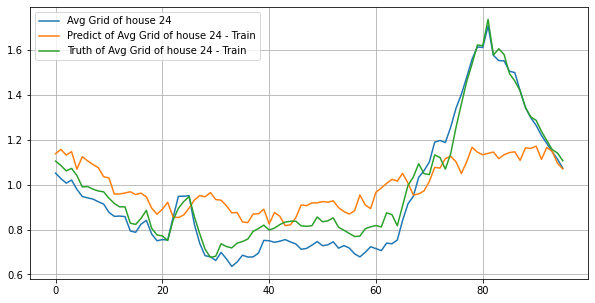

In [48]:
plt.figure(figsize=(10,5))
plt.plot(avgdayofh24, label= 'Avg Grid of house 24' )
plt.plot(avgdayofh24_pred1, label = 'Predict of Avg Grid of house 24 - Train')
plt.plot(avgdayofh24_True1, label = 'Truth of Avg Grid of house 24 - Train')
# plt.plot(avgdayofh24_pred2, label = 'Predict of Avg Grid of house 24 - Test')
# plt.plot(avgdayofh24_True2, label = 'Truth of Avg Grid of house 24 - Test')
plt.grid(True)
plt.legend()

In [49]:
avgdayofh16=get_avg_day(house=16)

trainX, trainY, testX, testY, dataset, scaler = dataset_per_house(nonsolarhouses1[-5])
print(testX.shape)
# dataset23 = np.reshape(dataset, (dataset.shape[0], dataset.shape[1], 1))
# print(dataset23.shape)
h16_pred1 = model.predict(trainX)
h16_pred2 = model.predict(testX)
# print(h23_pred.shape)
h16_pred1 = scaler.inverse_transform(h16_pred1)
h16_pred2 = scaler.inverse_transform(h16_pred2)
# print(h23_pred.shape)
avgdayofh16_pred1 = get_avg_day_from_predict(h16_pred1)
avgdayofh16_pred2 = get_avg_day_from_predict(h16_pred2)
# print(avgdayofh23_pred.shape)

17664
(5638, 96, 1)


In [51]:
# trainY.shape
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

avgdayofh16_True1 = get_avg_day_from_predict(trainY)
avgdayofh16_True2 = get_avg_day_from_predict(testY)

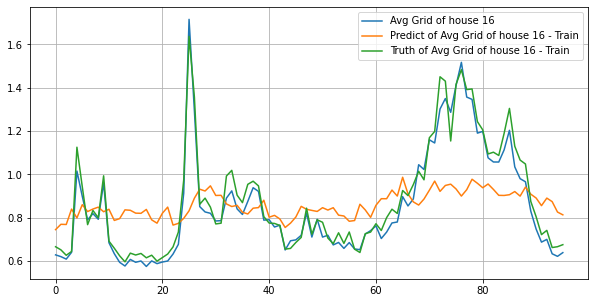

In [52]:
plt.figure(figsize=(10,5))
plt.plot(avgdayofh16, label= 'Avg Grid of house 16' )
plt.plot(avgdayofh16_pred1, label = 'Predict of Avg Grid of house 16 - Train')
plt.plot(avgdayofh16_True1, label = 'Truth of Avg Grid of house 16 - Train')
# plt.plot(avgdayofh16_pred2, label = 'Predict of Avg Grid of house 16 - Test')
# plt.plot(avgdayofh16_True2, label = 'Truth of Avg Grid of house 16 - Test')
plt.grid(True)
plt.legend()